## Dependencies

In [1]:
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
# from tensorflow_hub import KerasLayer

SEED = 42
seed_everything(SEED)
warnings.filterwarnings('ignore')

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [4]:
config = {
  "HEIGHT": 384,
  "WIDTH": 384,
  "HEIGHT_RS": 300,
  "WIDTH_RS": 300,
  "CHANNELS": 3,
  "BATCH_SIZE": 16,
  "EPOCHS": 110,
  "LEARNING_RATE": 5e-3,
  "ES_PATIENCE": 20,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB3',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-384x384',
  "INFERENCE": False
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config['LEARNING_RATE'] = config['LEARNING_RATE'] * config['BATCH_SIZE'] / 512 * REPLICAS
config

{'HEIGHT': 384,
 'WIDTH': 384,
 'HEIGHT_RS': 300,
 'WIDTH_RS': 300,
 'CHANNELS': 3,
 'BATCH_SIZE': 16,
 'EPOCHS': 110,
 'LEARNING_RATE': 0.00125,
 'ES_PATIENCE': 20,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'BASE_MODEL': 'EfficientNetB3',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'DATASET_PATH': 'melanoma-384x384',
 'INFERENCE': False}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(f"melanoma-{config['HEIGHT']}x{config['WIDTH']}")
GCS_2019_PATH = KaggleDatasets().get_gcs_path(f"isic2019-{config['HEIGHT']}x{config['WIDTH']}")
GCS_MALIGNANT_PATH = KaggleDatasets().get_gcs_path(f"malignant-v2-{config['HEIGHT']}x{config['WIDTH']}")

print(f"GCS: train: {count_data_items(tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec' % x for x in range(15)]))} test: {count_data_items(tf.io.gfile.glob([GCS_PATH + '/test%.2i*.tfrec' % x for x in range(15)]))}")
print(f"GCS_2019: train: {count_data_items(tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % x for x in range(30)]))}")
print(f"GCS_MALIGNANT: train: {count_data_items(tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % x for x in range(60)]))}")

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


GCS: train: 32692 test: 10305
GCS_2019: train: 25272
GCS_MALIGNANT: train: 3960


# Augmentations

In [6]:
def data_augment(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, config['HEIGHT'], shear=20.)
        else:
            image = transform_shear(image, config['HEIGHT'], shear=-20.)
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    if p_cutout > .5:
        image = data_augment_cutout(image)
    
    return image


def data_augment_tta(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    return image


def data_augment_spatial(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    crop_size = tf.random.uniform([], int(config['HEIGHT']*.7), config['HEIGHT'], dtype=tf.int32)
    
    if p_crop > .5:
        image = tf.image.random_crop(image, size=[crop_size, crop_size, config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .1), int(config['HEIGHT'] * .1)), 
                        max_mask_size=(int(config['HEIGHT'] * .125), int(config['HEIGHT'] * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image


def mixup(image, label, height=config['HEIGHT_RS'], width=config['WIDTH_RS'], 
          channels=3, batch_size=config['BATCH_SIZE'], classes=1):
    # input image - is a batch of images of size [batch_size, height, width, channels] not a single image of [height, width, channels]
    # output - a batch of images with mixup applied
    
    imgs = []; labs = []
    for j in range(batch_size):
        # random chose images
        k = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        alpha = tf.random.uniform([], 0, 1) # alpha
        # MixUp image
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-alpha)*img1 + alpha*img2)
        # MixUp label
        if classes > 1: # multi-class
            lab1 = tf.one_hot(label[j], classes)
            lab2 = tf.one_hot(label[k], classes)
        else:           # binary
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-alpha)*lab1 + alpha*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR
    image2 = tf.reshape(tf.stack(imgs), (batch_size, height, width, 3))
    label2 = tf.reshape(tf.stack(labs), (batch_size, classes))

    return image2, label2

def batch_mixup(images, labels, min_alpha=0, max_alpha=1, prob=1.0, batch_size=config['BATCH_SIZE'], classes=1):
    # Do `batch_mixup` with a probability = `PROBABILITY`
    # This is a tensor containing 0 or 1 -- 0: no mixup.
    # shape = [batch_size]
    do_mixup = tf.cast(tf.random.uniform([batch_size], 0, 1) <= prob, tf.int32)

    # Choose random images in the batch for mixup
    # shape = [batch_size]
    new_image_indices = tf.cast(tf.random.uniform([batch_size], 0, batch_size), tf.int32)
    
    # ratio of importance of the 2 images to be mixed up
    # shape = [batch_size]
    alpha = tf.random.uniform([batch_size], min_alpha, max_alpha) * tf.cast(do_mixup, tf.float32)  # this is beta dist with alpha=1.0
                
    # The second part corresponds to the images to be added to the original images `images`.
    new_images =  (1-alpha)[:, tf.newaxis, tf.newaxis, tf.newaxis] * images + alpha[:, tf.newaxis, tf.newaxis, tf.newaxis] * tf.gather(images, new_image_indices)

    # Make labels
    if classes > 1: # multi-class
        print('shape == 1')
        labels = tf.one_hot(labels, classes)
    new_labels =  (1-alpha)[:, tf.newaxis] * labels + alpha[:, tf.newaxis] * tf.gather(labels, new_image_indices)

    return new_images, new_labels

## Auxiliary functions

In [7]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
#     return example['image'], example['target']
    label = tf.cast(example['target'], tf.float32) # for MixUp
    return example['image'], label

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0
 
def prepare_image(img, augment=None, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = augment(img)
                      
    img = tf.image.resize(img, [config['HEIGHT_RS'], config['WIDTH_RS']])
    img = tf.reshape(img, [config['HEIGHT_RS'], config['WIDTH_RS'], 3])
    # img = tf.reshape(img, [dim, dim, 3])
            
    return img

def get_dataset(files, augment=None, shuffle=False, repeat=False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds


def get_dataset_sampling(files, augment=None, shuffle=False, repeat=False, 
                         labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), num_parallel_calls=AUTO)
    
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

110 total epochs and 47 steps per epoch
Learning rate schedule: 5e-06 to 0.00125 to 7.69e-06


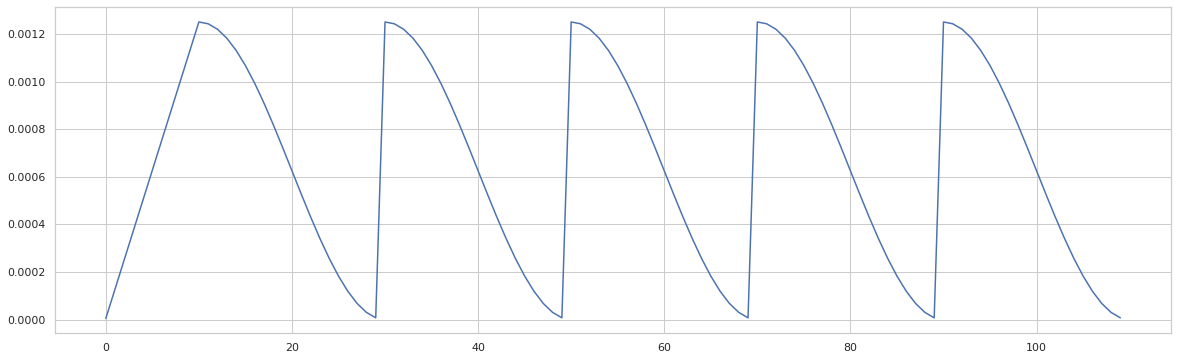

In [8]:
def cosine_with_hard_restarts_schedule_with_warmup(epoch):
    """ Create a schedule with a learning rate that decreases following the
    values of the cosine function with several hard restarts, after a warmup
    period during which it increases linearly between 0 and 1.
    """
    lr_start   = 5e-6
    lr_max     = config['LEARNING_RATE']
    lr_min     = 1e-6
    warmup_epochs = 10
    num_cycles = 5.
    total_epochs = config['EPOCHS']
    
    if epoch < warmup_epochs:
        lr = (lr_max - lr_start) / warmup_epochs * epoch + lr_start
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(math.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

def get_lr_callback():
    lr_callback = tf.keras.callbacks.LearningRateScheduler(cosine_with_hard_restarts_schedule_with_warmup, verbose=False)
    return lr_callback

total_epochs = config['EPOCHS']
steps_per_epoch = 47
rng = [i for i in range(0, total_epochs)]
y = [cosine_with_hard_restarts_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print(f'{total_epochs} total epochs and {steps_per_epoch} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to { max(y):.3g} to { y[-1]:.3g}')

# Model

In [9]:
def model_fn(input_shape=(256, 256, 3)):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB3(input_shape=input_shape, 
                                    weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False, 
                                    pooling='avg')

    x = base_model(input_image)
    
    output = L.Dense(1, activation='sigmoid', kernel_initializer='zeros', name='output')(x)

    model = Model(inputs=input_image, outputs=output)
    
    opt = optimizers.Adam(learning_rate=config['LEARNING_RATE'])
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    model.compile(optimizer=opt, loss=loss, metrics=['AUC'])

    return model

# Training

In [10]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []; history_list = []
preds = np.zeros((len(test), 1))

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec' % x for x in idxT])
    # Add external data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2+1) for x in idxT]) # 2019 data
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2) for x in idxT]) # 2018 data
    # Add extra malignant data
    TRAINING_MALIG_FILENAMES = tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % x for x in idxT]) # 2020 data
    TRAINING_MALIG_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2+1)+30) for x in idxT]) # 2019 data
    TRAINING_MALIG_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2)+30) for x in idxT]) # 2018 data
    TRAINING_MALIG_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % (x+15) for x in idxT]) # new data

    np.random.shuffle(TRAINING_FILENAMES)
    np.random.shuffle(TRAINING_MALIG_FILENAMES)
    ds_regular = get_dataset_sampling(TRAINING_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                      dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    ds_malig = get_dataset_sampling(TRAINING_MALIG_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                    dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    # Resampled TF Dataset
    resampled_ds = tf.data.experimental.sample_from_datasets([ds_regular, ds_malig], weights=[0.6, 0.4])
    # Add MixUp
#     resampled_ds = resampled_ds.batch(config['BATCH_SIZE']) # batch before augment
#     resampled_ds = resampled_ds.map(mixup, num_parallel_calls=AUTO)
#     resampled_ds = resampled_ds.map(batch_mixup, num_parallel_calls=AUTO)
#     resampled_ds = resampled_ds.unbatch().shuffle(1024*8) # unbatch to shuffle
    resampled_ds = resampled_ds.batch(config['BATCH_SIZE'] * REPLICAS).prefetch(AUTO)

    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    ct_valid = count_data_items(files_valid)
    ct_test = count_data_items(TEST_FILENAMES)
    VALID_STEPS = config['TTA_STEPS'] * ct_valid/config['BATCH_SIZE']/4/REPLICAS
    TEST_STEPS = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS
    
    ### MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((config['HEIGHT_RS'], config['WIDTH_RS'], config['CHANNELS']))

    model_path_last = f'model_{fold}_last.h5'
    es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)

    ### TRAIN
    history = model.fit(resampled_ds, 
                        validation_data=get_dataset(files_valid, augment=None, shuffle=False,
                                                    repeat=False, dim=config['HEIGHT']), 
                        steps_per_epoch=steps_per_epoch, 
                        callbacks=[es, get_lr_callback()], 
                        epochs=config['EPOCHS'], 
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path_last)

    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                           labeled=True, return_image_names=True)
    oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]))
    oof_folds.append(np.ones_like(oof_tar[-1], dtype='int8')*fold)
    ds = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                     labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=data_augment_tta,
                           repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'),axis=1))

    ### RESULTS
    auc = roc_auc_score(oof_tar[-1], oof_pred[-1])
    oof_val.append(np.max(history['val_auc']))
    print(f'#### FOLD {fold+1} OOF AUC = {oof_val[-1]:.3f}, with TTA = {auc:.3f}')

    if config['INFERENCE']:
        # PREDICT TEST USING TTA
        print('Predicting Test with TTA...')
        ds_test = get_dataset(TEST_FILENAMES, labeled=False, return_image_names=False, augment=data_augment_tta,
                              repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
        pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
        preds[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]
43933696/43933088 [==============================] - 1s 0us/step
Epoch 1/110
47/47 - 33s - loss: 0.6926 - auc: 0.5170 - val_loss: 0.6926 - val_auc: 0.5008 - lr: 5.0000e-06
Epoch 2/110
47/47 - 14s - loss: 0.5497 - auc: 0.8225 - val_loss: 0.2509 - val_auc: 0.6395 - lr: 1.2950e-04
Epoch 3/110
47/47 - 14s - loss: 0.4641 - auc: 0.8794 - val_loss: 0.2673 - val_auc: 0.7212 - lr: 2.5400e-04
Epoch 4/110
47/47 - 15s - loss: 0.4228 - auc: 0.9064 - val_loss: 0.2207 - val_auc: 0.8190 - lr: 3.7850e-04
Epoch 5/110
47/47 - 14s - loss: 0.4216 - auc: 0.9077 - val_loss: 0.1989 - val_auc: 0.8414 - lr: 5.0300e-04
Epoch 6/110
47/47 - 14s - loss: 0.4129 - auc: 0.9129 - val_loss: 0.2567 - val_auc: 0.8522 - lr: 6.2750e-04
Epoch 7/110
47/47 - 14s - loss: 0.3696 - auc: 0.9360 - val_loss: 0.2078 - val_auc: 0.8759 - lr: 7.5200e-04
Epoch 8/110
47/47 - 13s - loss: 0.3356 - auc: 0.9507 - val_loss: 0.2693 - val_auc: 0.8608 - lr: 8.7650e-04
Epoch 9

## Model loss graph

Fold: 1


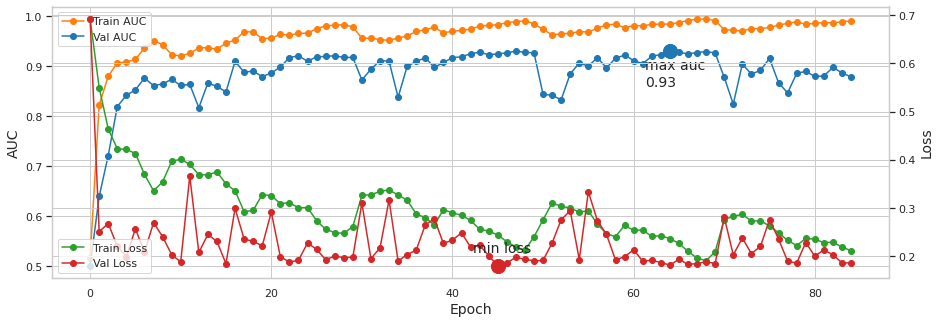

Fold: 2


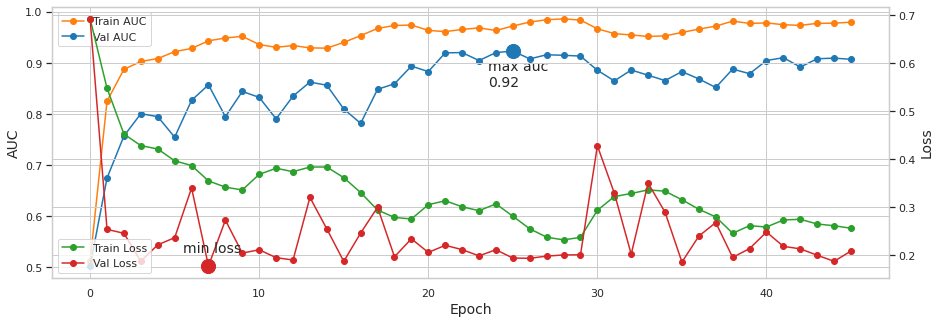

Fold: 3


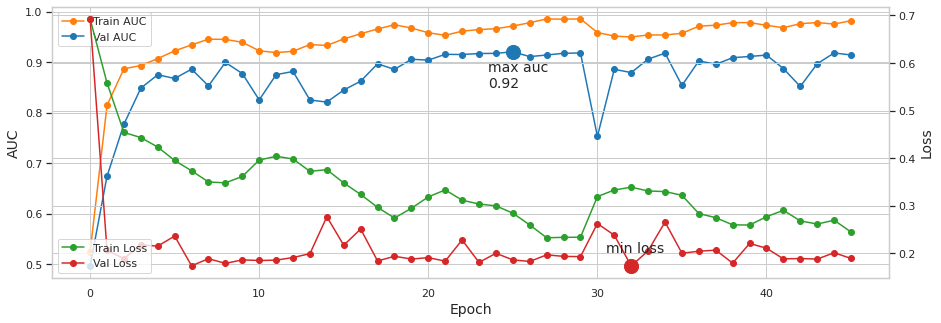

Fold: 4


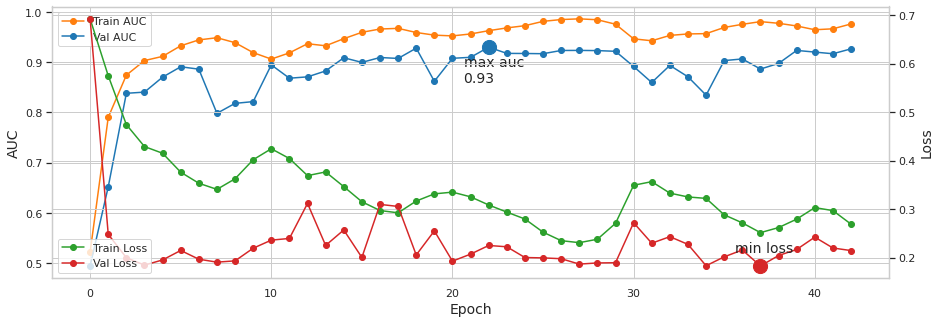

Fold: 5


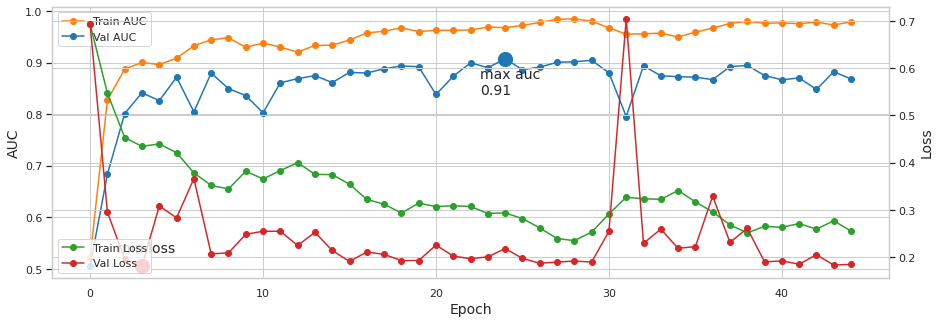

In [11]:
for n_fold, history in enumerate(history_list):
    print(f'Fold: {n_fold + 1}')
    epochs = np.arange(len(history['loss']))
    plt.figure(figsize=(15,5))
    plt.plot(epochs, history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(epochs, history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax(history['val_auc'])
    y = np.max(history['val_auc'])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(epochs, history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(epochs, history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'])
    y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.legend(loc=3)
    plt.show()

# Model evaluation

In [12]:
# COMPUTE OVERALL OOF AUC
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
oof = np.concatenate(oof_pred)
auc = roc_auc_score(true, oof)
print(f'Overall OOF AUC with TTA = {auc:.3f}')

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_name=names, fold=folds, target=true, pred=oof))
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())
display(df_oof.describe().T)

Overall OOF AUC with TTA = 0.926


,image_name,fold,target,pred
0,ISIC_2637011,0,0.0,0.044923
1,ISIC_0076262,0,0.0,0.032830
2,ISIC_0074268,0,0.0,0.030365
3,ISIC_0015719,0,0.0,0.028318
4,ISIC_0082543,0,0.0,0.035368


,count,mean,std,min,25%,50%,75%,max
fold,32692.0,2.000581,1.414549,0.000000,1.000000,2.000000,3.000000,4.000000
target,32692.0,0.017772,0.132105,0.000000,0.000000,0.000000,0.000000,1.000000
pred,32692.0,0.088137,0.151194,0.006708,0.022435,0.031476,0.065173,0.998955


# Visualize test predictions

In [13]:
if config['INFERENCE']:
    ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                     labeled=False, return_image_names=True)

    image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

    submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
    submission = submission.sort_values('image_name')

    print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")

    print('Top 10 samples')
    display(submission.head(10))

    print('Top 10 positive samples')
    display(submission.query('target > .5').head(10))

    fig = plt.subplots(figsize=(20, 4))
    plt.hist(submission['target'], bins=100)
    plt.title('Target', size=18)
    plt.show()

# Test set predictions

In [14]:
if config['INFERENCE']:
    display(submission.head(10))
    display(submission.describe().T)

    submission[['image_name', 'target']].to_csv('submission.csv', index=False)